# Crime detection project!

### Problem: Building a predictive machine learning model to identify the crime types based on other features. This would help in identifying future crimes likely to happen in the different hotspots and possibly try to stop them.

### Data: This dataset can be found on kaggle - https://www.kaggle.com/datasets/shamimhasan8/crime-and-safety-dataset/data

### Modelling: This is a classification problem so I will be using different classifiers like Random Forest Classifier, Logistic Regression, Decision Trees, Naive Bayes, etc for the modelling.

### Evaluation techniques: I will be using evaluation metrics like F1-Score, recall, confusion matrix and precision to evaluate the models created.

#### Importing the required tools

In [26]:
#EDA and plotting libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import datetime

#modelling libraries
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

#evaluation metrics
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix, precision_score

import warnings
warnings.filterwarnings("ignore")


In [27]:
#loading the data
data = pd.read_csv("C:\\Users\\aryas\\OneDrive\\Desktop\\crime-data\\crime_safety_dataset.csv")

### Preprocessing and summary of the dataset

In [28]:
def summary(df, show=True):
    summary_stats = {
        "First 5 Rows": df.head(),
        "Shape": df.shape,
        "Missing Values": df.isna().sum(),
        "Duplicate Values": df.duplicated().sum(),
    }

    if show:
        print("\n--- First 5 Rows ---")
        print(df.head())
        
        print("\n--- Shape ---")
        print(df.shape)

        print("\n--- Missing Values ---")
        print(df.isna().sum())

        print("\n--- Duplicate Rows ---")
        print(df.duplicated().sum())

        print("\n--- DataFrame Info ---")
        df.info()

    return summary_stats


In [29]:
summary(data)


--- First 5 Rows ---
   id        date      time crime_type          city state  \
0   1  09-09-2022  18:58:57   Homicide  Philadelphia    PA   
1   2  10-07-2022  12:10:59    Assault       Phoenix    AZ   
2   3  31-12-2024  09:26:12   Burglary   San Antonio    TX   
3   4  12-04-2024  23:17:28  Vandalism  Philadelphia    PA   
4   5  19-07-2023  04:49:39      Fraud   San Antonio    TX   

  location_description  victim_age victim_gender victim_race  
0        9916 Broadway          34          Male       Other  
1          6853 Oak St          13        Female       Black  
2       3760 Maple Ave          23          Male       Asian  
3         6781 Main St          36         Other       Asian  
4        3239 Broadway          26         Other       Other  

--- Shape ---
(1000, 10)

--- Missing Values ---
id                      0
date                    0
time                    0
crime_type              0
city                    0
state                   0
location_description 

{'First 5 Rows':    id        date      time crime_type          city state  \
 0   1  09-09-2022  18:58:57   Homicide  Philadelphia    PA   
 1   2  10-07-2022  12:10:59    Assault       Phoenix    AZ   
 2   3  31-12-2024  09:26:12   Burglary   San Antonio    TX   
 3   4  12-04-2024  23:17:28  Vandalism  Philadelphia    PA   
 4   5  19-07-2023  04:49:39      Fraud   San Antonio    TX   
 
   location_description  victim_age victim_gender victim_race  
 0        9916 Broadway          34          Male       Other  
 1          6853 Oak St          13        Female       Black  
 2       3760 Maple Ave          23          Male       Asian  
 3         6781 Main St          36         Other       Asian  
 4        3239 Broadway          26         Other       Other  ,
 'Shape': (1000, 10),
 'Missing Values': id                      0
 date                    0
 time                    0
 crime_type              0
 city                    0
 state                   0
 location_descrip

In [30]:
#converting the date and time columns into a structured format
data["date_time"] = pd.to_datetime(data["date"] + " " + data["time"], format="%d-%m-%Y %H:%M:%S")

In [31]:
data.drop(columns=["date","time"], inplace=True)

In [32]:
data.head()

,id,crime_type,city,state,location_description,victim_age,victim_gender,victim_race,date_time
0,1,Homicide,Philadelphia,PA,9916 Broadway,34,Male,Other,2022-09-09 18:58:57
1,2,Assault,Phoenix,AZ,6853 Oak St,13,Female,Black,2022-07-10 12:10:59
2,3,Burglary,San Antonio,TX,3760 Maple Ave,23,Male,Asian,2024-12-31 09:26:12
3,4,Vandalism,Philadelphia,PA,6781 Main St,36,Other,Asian,2024-04-12 23:17:28
4,5,Fraud,San Antonio,TX,3239 Broadway,26,Other,Other,2023-07-19 04:49:39


### EDA

In [33]:
def complete_eda(df, show=True):
    stats = {}

    # Univariate analysis
    def bar_plot(col, color, title):
        count = df[col].value_counts()
        stats[col] = count
        if show:
            print(f"\n {title}")
            print(count)
            count.plot(kind="bar", color=color, title=title)
            plt.xlabel(col.capitalize())
            plt.ylabel("Count")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

    univariate_cols = {
        'crime_type': ('darkblue', "Types of crimes taking place"),
        'victim_gender': ('purple', "Genders of the victims"),
        'city': ('brown', "Cities they belonged to"),
        'state': ('orange', "State-wise distribution"),
        'victim_race': ('green', "Racial distribution of victims"),
    }

    for col, (color, title) in univariate_cols.items():
        if col in df.columns:
            bar_plot(col, color, title)

    if 'victim_age' in df.columns:
        stats['victim_age'] = df['victim_age'].describe()
        if show:
            print("\n Distribution of Victim Ages:")
            print(stats['victim_age'])
            plt.figure(figsize=(8, 5))
            sns.histplot(df['victim_age'], bins=30, kde=True, color="teal")
            plt.title("Victim Age Distribution")
            plt.xlabel("Age")
            plt.ylabel("Frequency")
            plt.tight_layout()
            plt.show()

    # Correlation Heatmap
    numeric_cols = df.select_dtypes(include='number')
    if numeric_cols.shape[1] > 1:
        if show:
            print("\n Correlation Heatmap:")
            corr = numeric_cols.corr()
            plt.figure(figsize=(8, 6))
            sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
            plt.title("Correlation Matrix")
            plt.tight_layout()
            plt.show()

            # Pairplot
            print("\n Pair Plot of Numerical Columns:")
            sns.pairplot(df[numeric_cols.columns])
            plt.tight_layout()
            plt.show()

    # Bivariate analysis
    if show:
        print("\n")
        print("BIVARIATE ANALYSIS")
        print("")

    # Categorical vs Categorical
    cat_vs_cat_pairs = [
        ('crime_type', 'victim_gender'),
        ('crime_type', 'victim_race'),
        ('victim_gender', 'victim_race'),
        ('city', 'victim_gender')
    ]
    for col1, col2 in cat_vs_cat_pairs:
        if col1 in df.columns and col2 in df.columns:
            if show:
                print(f"\n {col1} vs {col2}")
                plt.figure(figsize=(10, 5))
                sns.countplot(data=df, x=col1, hue=col2, palette="Set2")
                plt.title(f"{col1} vs {col2}")
                plt.xlabel(col1.capitalize())
                plt.ylabel("Count")
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()

    # Categorical vs Numerical
    cat_vs_num_pairs = [
        ('crime_type', 'victim_age'),
        ('victim_gender', 'victim_age'),
        ('victim_race', 'victim_age'),
    ]
    for cat_col, num_col in cat_vs_num_pairs:
        if cat_col in df.columns and num_col in df.columns:
            if show:
                print(f"\n {cat_col} vs {num_col}")
                plt.figure(figsize=(10, 5))
                sns.boxplot(data=df, x=cat_col, y=num_col, palette="Set3")
                plt.title(f"{num_col} Distribution by {cat_col}")
                plt.xlabel(cat_col.capitalize())
                plt.ylabel(num_col.capitalize())
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()

    return stats




 Types of crimes taking place
Burglary             121
Domestic Violence    121
Homicide             101
Robbery              101
Arson                 98
Assault               97
Vandalism             94
Fraud                 89
Drug Offense          89
Theft                 89
Name: crime_type, dtype: int64


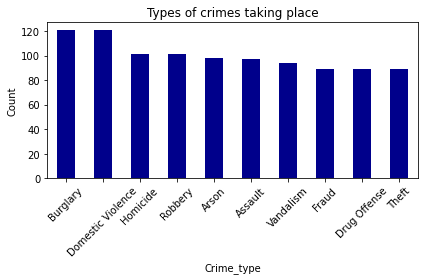


 Genders of the victims
Male          272
Female        259
Other         237
Non-binary    232
Name: victim_gender, dtype: int64


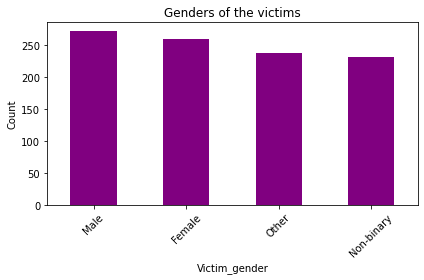


 Cities they belonged to
Houston         106
Dallas          106
New York        105
Los Angeles     102
Chicago         101
Philadelphia     99
Phoenix          98
San Jose         97
San Antonio      95
San Diego        91
Name: city, dtype: int64


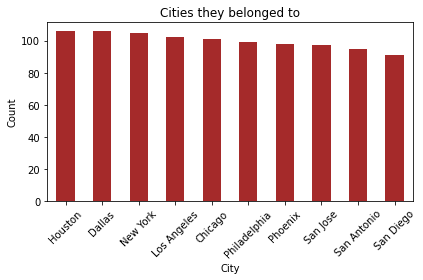


 State-wise distribution
TX    307
CA    290
NY    105
IL    101
PA     99
AZ     98
Name: state, dtype: int64


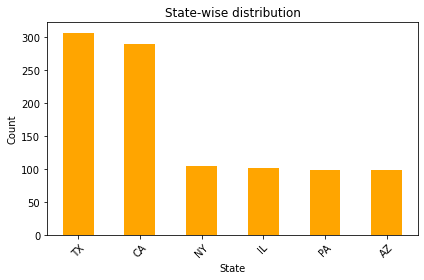


 Racial distribution of victims
Other       211
Asian       211
White       206
Hispanic    187
Black       185
Name: victim_race, dtype: int64


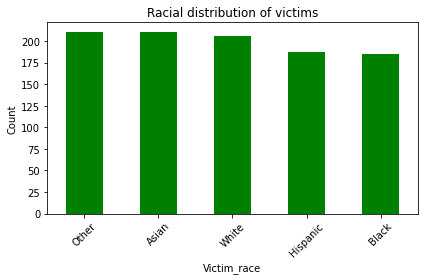


 Distribution of Victim Ages:
count    1000.000000
mean       52.201000
std        22.913831
min        12.000000
25%        33.000000
50%        53.000000
75%        72.000000
max        90.000000
Name: victim_age, dtype: float64


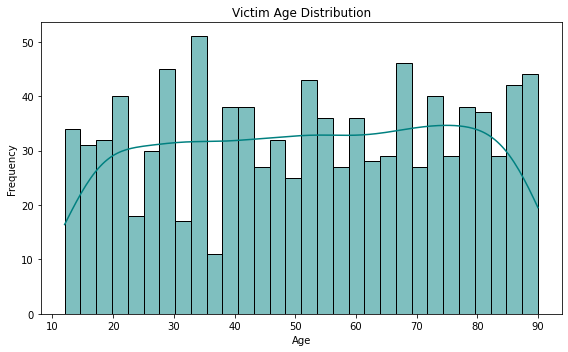


 Correlation Heatmap:


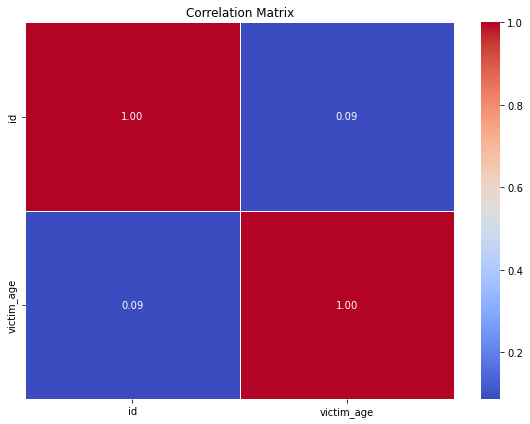


 Pair Plot of Numerical Columns:


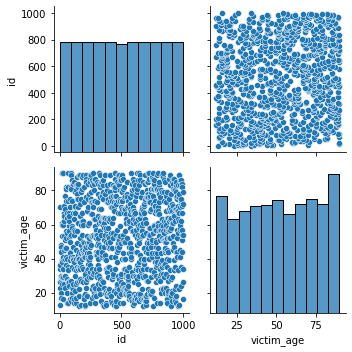



BIVARIATE ANALYSIS


 crime_type vs victim_gender


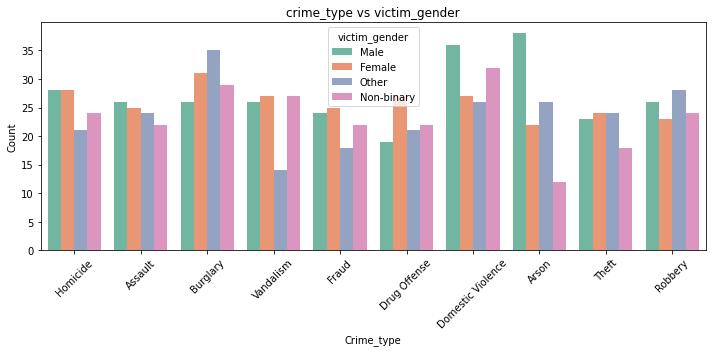


 crime_type vs victim_race


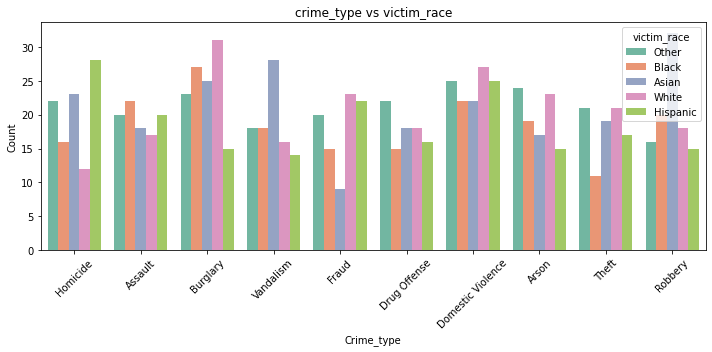


 victim_gender vs victim_race


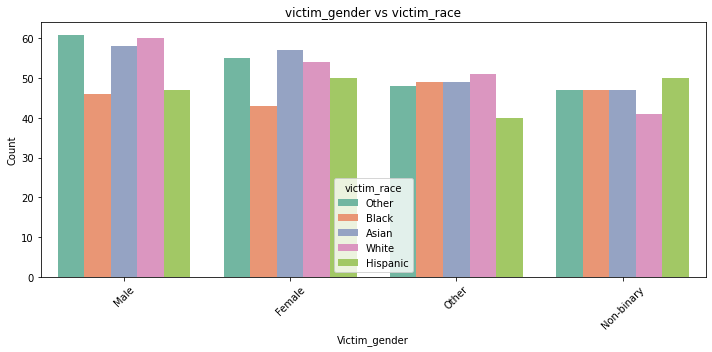


 city vs victim_gender


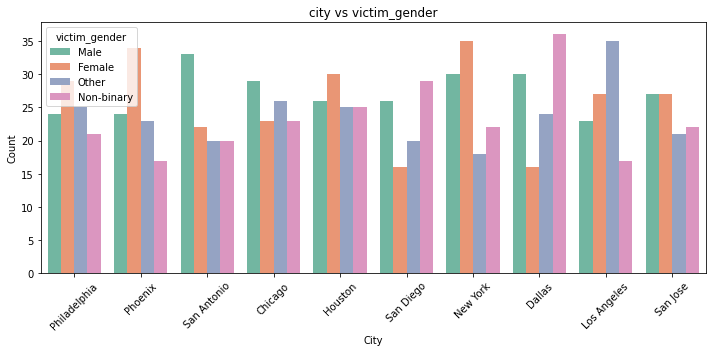


 crime_type vs victim_age


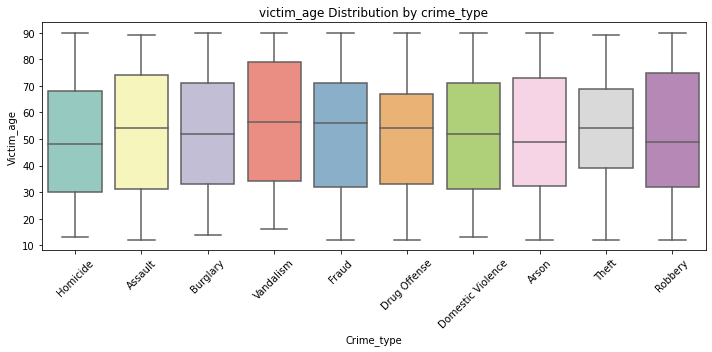


 victim_gender vs victim_age


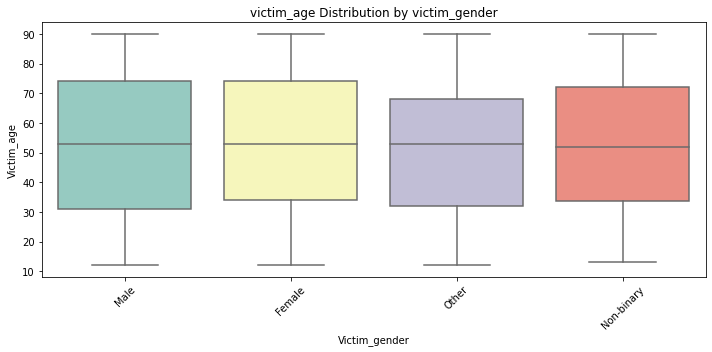


 victim_race vs victim_age


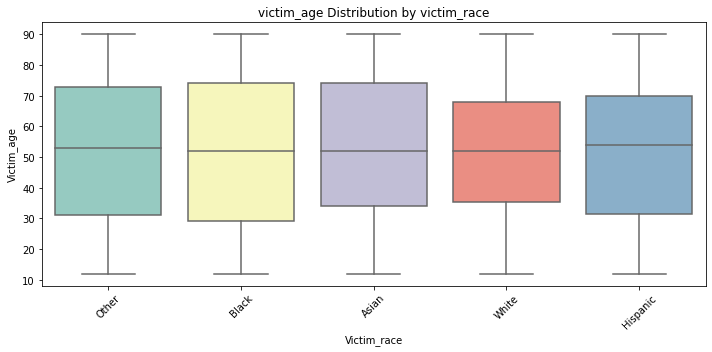

{'crime_type': Burglary             121
 Domestic Violence    121
 Homicide             101
 Robbery              101
 Arson                 98
 Assault               97
 Vandalism             94
 Fraud                 89
 Drug Offense          89
 Theft                 89
 Name: crime_type, dtype: int64,
 'victim_gender': Male          272
 Female        259
 Other         237
 Non-binary    232
 Name: victim_gender, dtype: int64,
 'city': Houston         106
 Dallas          106
 New York        105
 Los Angeles     102
 Chicago         101
 Philadelphia     99
 Phoenix          98
 San Jose         97
 San Antonio      95
 San Diego        91
 Name: city, dtype: int64,
 'state': TX    307
 CA    290
 NY    105
 IL    101
 PA     99
 AZ     98
 Name: state, dtype: int64,
 'victim_race': Other       211
 Asian       211
 White       206
 Hispanic    187
 Black       185
 Name: victim_race, dtype: int64,
 'victim_age': count    1000.000000
 mean       52.201000
 std        22.913831
 m

In [34]:
complete_eda(data)

### Modelling

In [35]:
data.head()

,id,crime_type,city,state,location_description,victim_age,victim_gender,victim_race,date_time
0,1,Homicide,Philadelphia,PA,9916 Broadway,34,Male,Other,2022-09-09 18:58:57
1,2,Assault,Phoenix,AZ,6853 Oak St,13,Female,Black,2022-07-10 12:10:59
2,3,Burglary,San Antonio,TX,3760 Maple Ave,23,Male,Asian,2024-12-31 09:26:12
3,4,Vandalism,Philadelphia,PA,6781 Main St,36,Other,Asian,2024-04-12 23:17:28
4,5,Fraud,San Antonio,TX,3239 Broadway,26,Other,Other,2023-07-19 04:49:39


In [36]:
#dropping the unnecessary columns
data.drop(columns=["location_description"],inplace=True)

In [37]:
data.head()

,id,crime_type,city,state,victim_age,victim_gender,victim_race,date_time
0,1,Homicide,Philadelphia,PA,34,Male,Other,2022-09-09 18:58:57
1,2,Assault,Phoenix,AZ,13,Female,Black,2022-07-10 12:10:59
2,3,Burglary,San Antonio,TX,23,Male,Asian,2024-12-31 09:26:12
3,4,Vandalism,Philadelphia,PA,36,Other,Asian,2024-04-12 23:17:28
4,5,Fraud,San Antonio,TX,26,Other,Other,2023-07-19 04:49:39


In [38]:
#creating a copy of our original datset
model_data = data.copy()

# Extracting the hour from the datetime
model_data["hour"] = model_data["date_time"].dt.hour
#prepareing the predictors and target variable
columns_required = ["city","victim_age","victim_gender","victim_race","hour","state"]

#predictor
x = model_data[columns_required]
#target
y = model_data["crime_type"]

In [39]:
#onehot encode the categorical features
cat_features = ["city","victim_gender","victim_race","state"]
x = pd.get_dummies(x,columns=cat_features, drop_first= True)

#splitting data into train and test sets
x_train,x_test, y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state=42)

In [40]:
# Scale the data for Logistic Regression only
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Store predictions for plotting later
conf_matrices = {}

# Dictionary to store the results
model_scores = {}

# Logistic Regression
log_model = LogisticRegression(max_iter=2000)
log_model.fit(x_train_scaled, y_train)
log_preds = log_model.predict(x_test_scaled)
log_acc = accuracy_score(y_test, log_preds)
log_prec = precision_score(y_test, log_preds, average='weighted', zero_division=0)
log_f1 = f1_score(y_test, log_preds, average='weighted')
model_scores['Logistic Regression'] = [log_acc, log_prec, log_f1]
conf_matrices['Logistic Regression'] = confusion_matrix(y_test, log_preds)

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(x_train, y_train)
tree_preds = tree_model.predict(x_test)
tree_acc = accuracy_score(y_test, tree_preds)
tree_prec = precision_score(y_test, tree_preds, average='weighted', zero_division=0)
tree_f1 = f1_score(y_test, tree_preds, average='weighted')
model_scores['Decision Tree'] = [tree_acc, tree_prec, tree_f1]
conf_matrices['Decision Tree'] = confusion_matrix(y_test, tree_preds)

# Naive Bayes (MultinomialNB)
nb_model = MultinomialNB()
nb_model.fit(x_train, y_train)
nb_preds = nb_model.predict(x_test)
nb_acc = accuracy_score(y_test, nb_preds)
nb_prec = precision_score(y_test, nb_preds, average='weighted', zero_division=0)
nb_f1 = f1_score(y_test, nb_preds, average='weighted')
model_scores['Naive Bayes'] = [nb_acc, nb_prec, nb_f1]
conf_matrices['Naive Bayes'] = confusion_matrix(y_test, nb_preds)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train, y_train)
rf_preds = rf_model.predict(x_test)
rf_acc = accuracy_score(y_test, rf_preds)
rf_prec = precision_score(y_test, rf_preds, average='weighted', zero_division=0)
rf_f1 = f1_score(y_test, rf_preds, average='weighted')
model_scores['Random Forest'] = [rf_acc, rf_prec, rf_f1]
conf_matrices['Random Forest'] = confusion_matrix(y_test, rf_preds)

# Print all results
for model, scores in model_scores.items():
    print(f"\n{model}")
    print(f"Accuracy : {scores[0]:.2f}")
    print(f"Precision: {scores[1]:.2f}")
    print(f"F1 Score : {scores[2]:.2f}")


Logistic Regression
Accuracy : 0.14
Precision: 0.13
F1 Score : 0.12

Decision Tree
Accuracy : 0.10
Precision: 0.10
F1 Score : 0.09

Naive Bayes
Accuracy : 0.10
Precision: 0.11
F1 Score : 0.09

Random Forest
Accuracy : 0.12
Precision: 0.13
F1 Score : 0.12


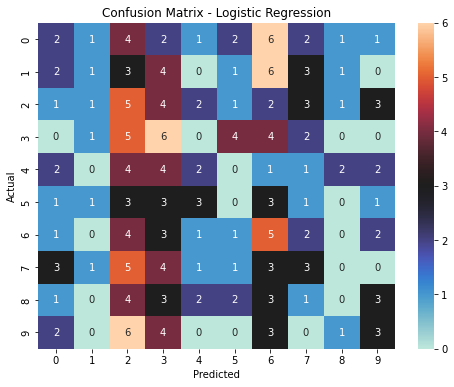

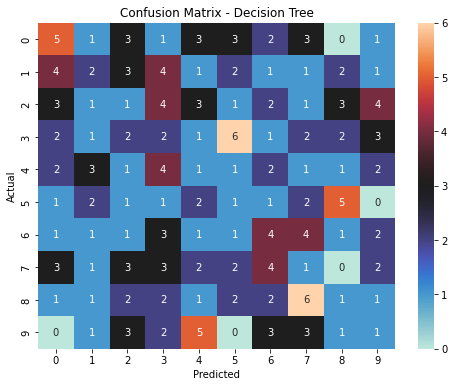

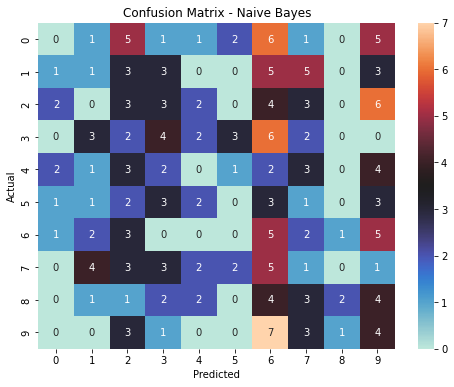

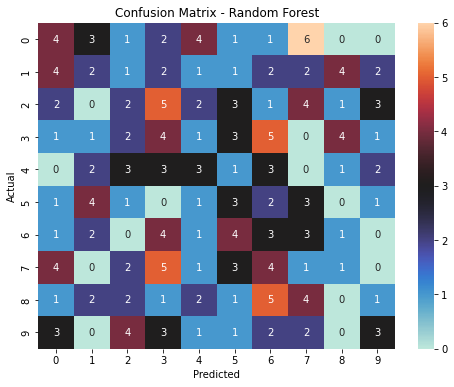

In [41]:
# Plot confusion matrix heatmaps
for model_name, cm in conf_matrices.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='icefire')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

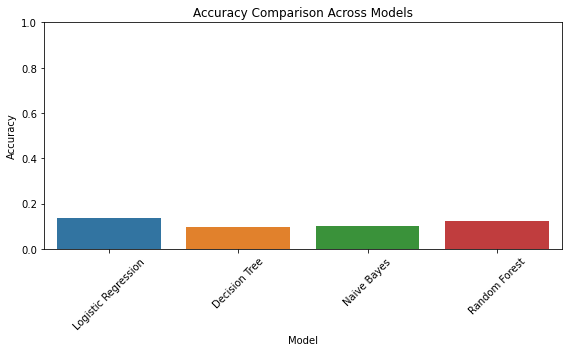

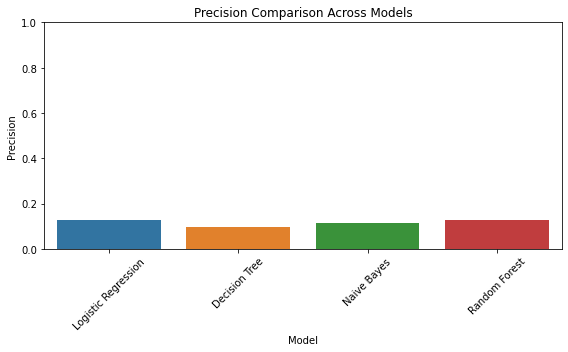

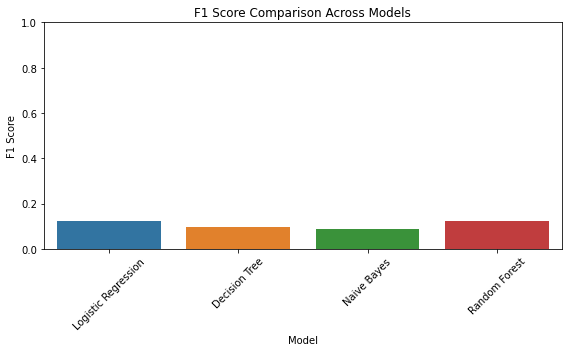

In [42]:
# Convert model_scores dictionary to a DataFrame for easy plotting
scores_df = pd.DataFrame(model_scores, index=['Accuracy', 'Precision', 'F1 Score']).T

# Plotting each metric
for metric in scores_df.columns:
    plt.figure(figsize=(8, 5))
    sns.barplot(x=scores_df.index, y=scores_df[metric])
    plt.title(f'{metric} Comparison Across Models')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.ylim(0, 1)  # Because scores are between 0 and 1
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Observations:
1. Logistic Regression performed well after scaling, with balanced accuracy and F1 score.

2. Decision Tree showed signs of overfitting; training accuracy was high but test performance dropped.

3. Naive Bayes had the lowest accuracy, likely due to strong independence assumptions.

4. Random Forest gave the best overall results with high accuracy and robustness.

5. Confusion matrices showed that some models struggled with specific class predictions. 